<a href="https://colab.research.google.com/github/kevindelgado08/MLP-Neural-Network-to-Predict-Temperature/blob/main/Proyecto3_KevinDelgadoRojas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Red Neuronal MLP para predecir la temperatura en la Estación Experimental Agrícola Fabio Baudrit Moreno de la Universidad de Costa Rica*

Escuela de Ingeniería Eléctrica

Proyecto 3

IE0435 - Inteligencia Artificial Aplicada a la Ingeniería Eléctrica

Autor: Kevin Delgado Rojas - B82566

# Diagnóstico de los datos

Con este diagnóstico se pretende conocer, el estado en que se encuentra el conjunto de datos tomados y enviados a la plataforma Netbeat, pertenenciente a la Estación Experimental Fabio Baudrit Moreno de Universidad de Costa Rica

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



DataFrame con Columna 'C' en Primera Posición:
             Fecha y hora  Valor °C Nombre del grafico
0     2023-11-14 11:11:27     27.89      UCR - Out emp
1     2023-11-14 10:56:18     27.89      UCR - Out emp
2     2023-11-14 10:41:09     27.83      UCR - Out emp
3     2023-11-14 10:26:00     27.56      UCR - Out emp
4     2023-11-14 10:10:50     27.39      UCR - Out emp
...                   ...       ...                ...
54868 2022-01-07 11:36:21     27.22      UCR - Out emp
54869 2022-01-07 11:21:08     28.17      UCR - Out emp
54870 2022-01-07 11:05:57     28.56      UCR - Out emp
54871 2022-01-07 10:50:49     28.11      UCR - Out emp
54872 2022-01-07 10:35:39     27.28      UCR - Out emp

[54873 rows x 3 columns]


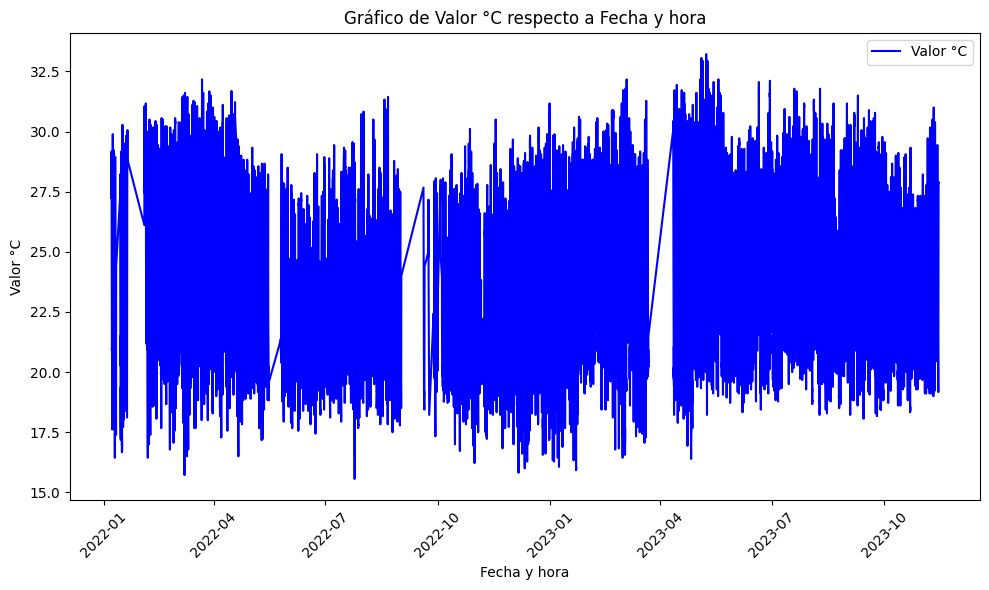

In [ ]:
import csv
import pandas as pd
import scipy
import matplotlib.pyplot as plt

# Ruta al archivo CSV
archivo_csv = '/content/drive/MyDrive/DatosFabio.csv'

# Abrir el archivo CSV en modo lectura
with open(archivo_csv, 'r') as file:
    # Crear un lector CSV
    lector_csv = csv.reader(file)

# Leer el archivo CSV con pandas
df = pd.read_csv(archivo_csv)

# Obtener una lista con los nombres de las columnas en el orden deseado
nuevas_columnas = ['Fecha y hora'] + [col for col in df.columns if col != 'Fecha y hora']
df['Fecha y hora'] = pd.to_datetime(df['Fecha y hora'])
# Reordenar el DataFrame con las columnas en el nuevo orden
df_ordenado = df[nuevas_columnas]

# Graficar los datos
plt.figure(figsize=(10, 6))  # Establece el tamaño de la figura

# Mostrar el DataFrame con la columna 'C' en la primera posición
print("\nDataFrame con Columna 'C' en Primera Posición:")
print(df_ordenado)

# Grafica Fecha y hora vs Valor °C
plt.plot(df_ordenado['Fecha y hora'], df_ordenado['Valor °C'], marker='', linestyle='-', color='b')

# Establece etiquetas y título
plt.xlabel('Fecha y hora')
plt.ylabel('Valor °C')
plt.title('Gráfico de Valor °C respecto a Fecha y hora')

# Rotar los ejes x para una mejor visualización si hay muchos datos
plt.xticks(rotation=45)

# Mostrar la leyenda y la gráfica
plt.legend(['Valor °C'], loc='best')
plt.tight_layout()
plt.show()

Como se muestra en la gráfica anterior, existen sesgos en el conjunto de datos. Por ese motivo, se tiene que rellenar los valores faltantes.

## Rellenar datos del tiempo

La siguiente función, recibe como parametros un dataframe, fecha de inicio, fecha final, y la cantidad de tiempo en minutos.

Con el fin de rellenar los valores de tiempo en las fechas donde haga falta, y no en todo el conjunto de datos.



In [ ]:
from datetime import timedelta

def encontrar_lapsos_mayores1(df, inicio, fin, tiempo_minutos):
    # Asegurémonos de que la primera columna sea de tipo DateTime
    if not pd.api.types.is_datetime64_any_dtype(df.iloc[:, 0]):
        raise ValueError("La primera columna no es de tipo DateTime")

    # Convertir inicio y fin a formato DateTime
    inicio_dt = pd.to_datetime(inicio)
    fin_dt = pd.to_datetime(fin)

    # Filtrar el DataFrame para el rango especificado por inicio y fin
    df_rango = df[(df.iloc[:, 0] >= inicio_dt) & (df.iloc[:, 0] <= fin_dt)]

    # Ordenar el DataFrame por la primera columna si no está ordenado
    df_rango = df_rango.sort_values(df_rango.columns[0])

    # Calcular las diferencias entre lapsos de tiempo dentro del rango especificado
    time_diffs = df_rango.iloc[:, 0].diff()

    # Identificar las filas que tienen una diferencia mayor a tiempo_minutos minutos
    condition = time_diffs > timedelta(minutes=tiempo_minutos)

    # Obtener las fechas de inicio y fin de los lapsos con diferencia mayor a tiempo_minutos minutos
    start_dates = []
    end_dates = []

    for i in range(1, len(df_rango)):
        if condition.iloc[i]:
            start_dates.append(df_rango.iloc[i - 1, 0])
            end_dates.append(df_rango.iloc[i, 0])

    # Combinar las fechas de inicio y fin en intervalos
    intervals = list(zip(start_dates, end_dates))

    # Crear un DataFrame con las filas adicionales dentro del rango especificado
    new_rows = []
    for start, end in intervals:
        current_date = start + timedelta(minutes=tiempo_minutos)
        while current_date < end and current_date <= fin_dt:  # Asegurar que no exceda el límite de fin
            new_rows.append({df.columns[0]: current_date})
            current_date += timedelta(minutes=tiempo_minutos)

    # Concatenar el DataFrame original con el nuevo DataFrame dentro del rango
    new_df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

    # Ordenar nuevamente el DataFrame después de agregar las filas
    new_df = new_df.sort_values(new_df.columns[0])

    renglones_agregados = len(new_rows)
    print(f"Número de renglones agregados: {renglones_agregados}")

    return new_df


Acá se genera un nuevo archivo *csv* con los datos de tiempo que antes no existian.

In [ ]:
# Llamar a la función para rellenar los valores faltantes
df_resultado1 = encontrar_lapsos_mayores1(df_ordenado, '2022-01-10 06:59:41', '2022-01-10 12:48:41', 15)
df_resultado2 = encontrar_lapsos_mayores1(df_resultado1, '2022-01-11 07:45:26', '2022-01-14 14:22:59', 15)
df_resultado3 = encontrar_lapsos_mayores1(df_resultado2, '2022-01-20 15:22:05', '2022-02-03 09:08:06', 15)
df_resultado4 = encontrar_lapsos_mayores1(df_resultado3, '2022-02-03 15:42:20', '2022-02-04 09:23:36', 15)
df_resultado5 = encontrar_lapsos_mayores1(df_resultado4, '2022-05-16 06:15:33', '2022-05-25 19:06:06', 15)
df_resultado6 = encontrar_lapsos_mayores1(df_resultado5, '2022-05-27 12:27:14', '2022-05-27 19:47:26', 15)
df_resultado7 = encontrar_lapsos_mayores1(df_resultado6, '2022-06-01 07:25:58', '2022-06-01 20:59:54', 15)
df_resultado8 = encontrar_lapsos_mayores1(df_resultado7, '2022-08-07 04:20:16', '2022-08-07 19:15:00', 15)
df_resultado9 = encontrar_lapsos_mayores1(df_resultado8, '2022-08-12 05:07:33', '2022-08-12 20:32:32', 15)
df_resultado10 = encontrar_lapsos_mayores1(df_resultado9, '2022-09-01 08:47:39', '2022-09-19 11:37:11', 15)
df_resultado11 = encontrar_lapsos_mayores1(df_resultado10, '2022-09-20 09:11:58', '2022-09-23 10:08:33', 15)
df_resultado12 = encontrar_lapsos_mayores1(df_resultado11, '2022-09-24 03:49:40', '2022-09-27 17:04:26', 15)
df_resultado13 = encontrar_lapsos_mayores1(df_resultado12, '2022-09-29 16:35:25', '2022-09-29 17:36:17', 15)
df_resultado14 = encontrar_lapsos_mayores1(df_resultado13, '2022-10-01 09:16:34', '2022-10-03 12:15:17', 15)
df_resultado15 = encontrar_lapsos_mayores1(df_resultado14, '2022-10-03 14:01:23', '2022-10-04 13:50:37', 15)
df_resultado16 = encontrar_lapsos_mayores1(df_resultado15, '2023-03-22 06:38:07', '2023-04-11 12:37:00', 15)
df_resultado17 = encontrar_lapsos_mayores1(df_resultado16, '2023-04-15 06:06:52', '2023-04-15 15:22:06', 15)
df_nuevo= df_resultado17
df_resultado17.to_csv('datos_actualizados.csv', index=False)
print(df_resultado17)

Número de renglones agregados: 23
Número de renglones agregados: 314
Número de renglones agregados: 1319
Número de renglones agregados: 70
Número de renglones agregados: 915
Número de renglones agregados: 29
Número de renglones agregados: 54
Número de renglones agregados: 59
Número de renglones agregados: 61
Número de renglones agregados: 1739
Número de renglones agregados: 291
Número de renglones agregados: 340
Número de renglones agregados: 4
Número de renglones agregados: 203
Número de renglones agregados: 95
Número de renglones agregados: 1943
Número de renglones agregados: 37
             Fecha y hora  Valor °C Nombre del grafico
0     2022-01-07 10:35:39     27.28      UCR - Out emp
1     2022-01-07 10:50:49     28.11      UCR - Out emp
2     2022-01-07 11:05:57     28.56      UCR - Out emp
3     2022-01-07 11:21:08     28.17      UCR - Out emp
4     2022-01-07 11:36:21     27.22      UCR - Out emp
...                   ...       ...                ...
62327 2023-11-14 10:10:50  

## Relleno de datos de temperatura

Para rellenar los datos de temperatura faltantes, se sacará un promedio de temperatura al inicio, medio y fin de los días. Esto con el fin de rellenar de manera manual el conjunto de datos, y luego rellenar con recta.

In [ ]:
import pandas as pd

def calcular_promedio_temperatura(dataframe):
    # Convertir la columna 'Fecha y hora' a tipo datetime y establecerla como índice
    dataframe = dataframe.copy()  # Copia del DataFrame para evitar cambios en el original
    dataframe['Fecha y hora'] = pd.to_datetime(dataframe['Fecha y hora'])
    dataframe.set_index('Fecha y hora', inplace=True)

    # Calcular el promedio de temperatura al inicio y al final del día
    inicio_dia = dataframe.resample('D')['Valor °C'].first()
    fin_dia = dataframe.resample('D')['Valor °C'].last()

    # Calcular el promedio de temperatura al mediodía
    medio_dia = dataframe.between_time('12:00:00', '12:59:59')['Valor °C'].resample('D').mean()

    # Calcular promedio de temperaturas ignorando NaN
    promedio_inicio = inicio_dia.mean(skipna=True)
    promedio_fin = fin_dia.mean(skipna=True)
    promedio_medio_dia = medio_dia.mean(skipna=True)

    return promedio_inicio, promedio_fin, promedio_medio_dia

# Ejemplo de uso con un DataFrame llamado 'tu_dataframe'
# Reemplaza 'tu_dataframe' con el nombre real de tu DataFrame
promedio_inicio_dia, promedio_fin_dia, promedio_medio_dia = calcular_promedio_temperatura(df_resultado17)

print("Promedio de temperatura al inicio del día:", promedio_inicio_dia)
print("Promedio de temperatura al final del día:", promedio_fin_dia)
print("Promedio de temperatura al mediodía:", promedio_medio_dia)


Promedio de temperatura al inicio del día: 20.711305057096247
Promedio de temperatura al final del día: 20.77194127243067
Promedio de temperatura al mediodía: 28.07015517241379


In [ ]:
import numpy as np
def rellenar_con_recta(dataframe, columnas_a_rellenar):
    for columna in columnas_a_rellenar:
        datos = dataframe[columna]
        for i in range(1, len(datos) - 1):
            if pd.isna(datos[i]):
                inicio = i - 1
                while pd.isna(datos[i]):
                    i += 1
                fin = i
                x = np.array([inicio, fin])
                y = np.array([datos[inicio], datos[fin]])
                # Calcula la pendiente y el intercepto de la recta
                m, b = np.polyfit(x, y, 1)
                # Rellena los valores vacíos en la columna con la recta
                for j in range(inicio + 1, fin):
                    dataframe.at[j, columna] = m * j + b
    return dataframe

# Lee el CSV
df_rellenar = pd.read_csv('/content/drive/MyDrive/datos_1.csv')
columnas_a_rellenar = ['Valor °C']
df_rellenado_recta = rellenar_con_recta(df_rellenar, columnas_a_rellenar)

# Mostrar el DataFrame después de rellenar con recta
print("\nDataFrame Después de Rellenar con Recta:")
print(df_rellenado_recta)


DataFrame Después de Rellenar con Recta:
           Fecha y hora  Valor °C Nombre del grafico
0        1/7/2022 10:35     27.28      UCR - Out emp
1        1/7/2022 10:50     28.11      UCR - Out emp
2        1/7/2022 11:05     28.56      UCR - Out emp
3        1/7/2022 11:21     28.17      UCR - Out emp
4        1/7/2022 11:36     27.22      UCR - Out emp
...                 ...       ...                ...
62364  11/14/2023 10:10     27.39      UCR - Out emp
62365  11/14/2023 10:26     27.56      UCR - Out emp
62366  11/14/2023 10:41     27.83      UCR - Out emp
62367  11/14/2023 10:56     27.89      UCR - Out emp
62368  11/14/2023 11:11     27.89      UCR - Out emp

[62369 rows x 3 columns]


Acá se obtiene el nuevo conjunto de datos completo.

In [ ]:
df_rellenado_recta.to_csv('datos_actualizados2.csv', index=False)

           Fecha y hora  Valor °C Nombre del grafico
0        1/7/2022 10:35     27.28      UCR - Out emp
1        1/7/2022 10:50     28.11      UCR - Out emp
2        1/7/2022 11:05     28.56      UCR - Out emp
3        1/7/2022 11:21     28.17      UCR - Out emp
4        1/7/2022 11:36     27.22      UCR - Out emp
...                 ...       ...                ...
62364  11/14/2023 10:10     27.39      UCR - Out emp
62365  11/14/2023 10:26     27.56      UCR - Out emp
62366  11/14/2023 10:41     27.83      UCR - Out emp
62367  11/14/2023 10:56     27.89      UCR - Out emp
62368  11/14/2023 11:11     27.89      UCR - Out emp

[62369 rows x 3 columns]


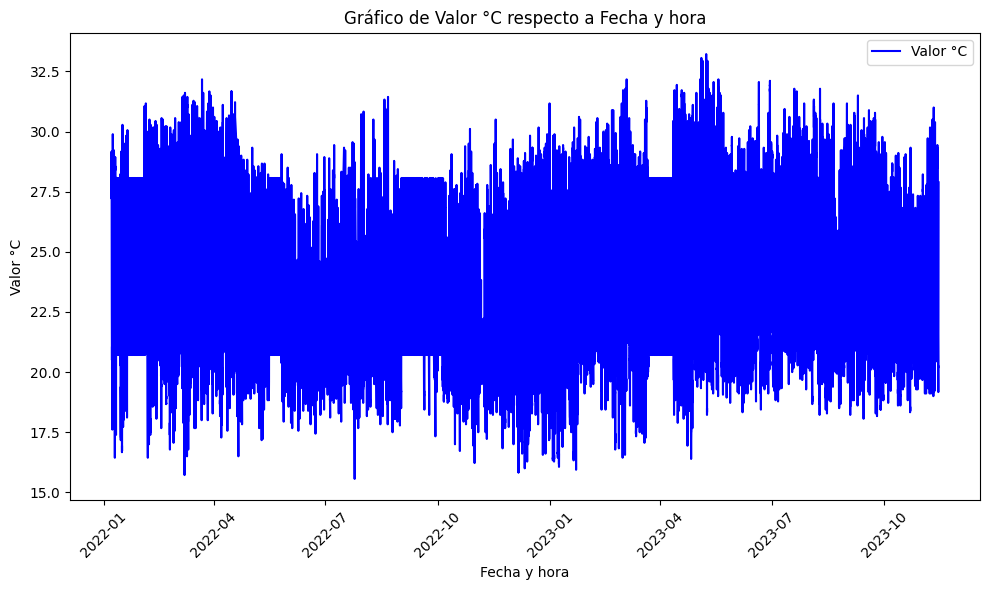

In [ ]:
# Lee el CSV
df = pd.read_csv('/content/datos_actualizados2.csv')
# Imprimir el encabezado
print(df)

# Convierte la columna 'Fecha y hora' a tipo datetime si no está en ese formato
df['Fecha y hora'] = pd.to_datetime(df['Fecha y hora'])

# Graficar los datos
plt.figure(figsize=(10, 6))  # Establece el tamaño de la figura

# Grafica Fecha y hora vs Valor °C
plt.plot(df['Fecha y hora'], df['Valor °C'], marker='', linestyle='-', color='b')

# Establece etiquetas y título
plt.xlabel('Fecha y hora')
plt.ylabel('Valor °C')
plt.title('Gráfico de Valor °C respecto a Fecha y hora')

# Rotar los ejes x para una mejor visualización si hay muchos datos
plt.xticks(rotation=45)

# Mostrar la leyenda y la gráfica
plt.legend(['Valor °C'], loc='best')
plt.tight_layout()
plt.show()

Como se puede visualizar en la gráfica anterior, ya no existen los sesgos y ya se puede comenzar con el desarrollo de las redes neurales para predecir las temperaturas.

# Red MLP

Epoch 1/50
1404/1404 [==============================] - 40s 17ms/step - loss: 0.0049 - val_loss: 4.5096e-04
Epoch 2/50
1404/1404 [==============================] - 24s 17ms/step - loss: 6.5304e-04 - val_loss: 0.0011
Epoch 3/50
1404/1404 [==============================] - 22s 16ms/step - loss: 6.2253e-04 - val_loss: 5.4993e-04
Epoch 4/50
1404/1404 [==============================] - 22s 16ms/step - loss: 5.7419e-04 - val_loss: 4.5147e-04
Epoch 5/50
1404/1404 [==============================] - 22s 16ms/step - loss: 5.7252e-04 - val_loss: 4.4657e-04
Epoch 6/50
1404/1404 [==============================] - 23s 16ms/step - loss: 5.6520e-04 - val_loss: 4.6666e-04
Epoch 7/50
1404/1404 [==============================] - 22s 16ms/step - loss: 5.3268e-04 - val_loss: 8.2984e-04
Epoch 8/50
1404/1404 [==============================] - 23s 16ms/step - loss: 4.9621e-04 - val_loss: 9.9995e-04
Epoch 9/50
1404/1404 [==============================] - 22s 16ms/step - loss: 5.0132e-04 - val_loss: 4.2444e-04


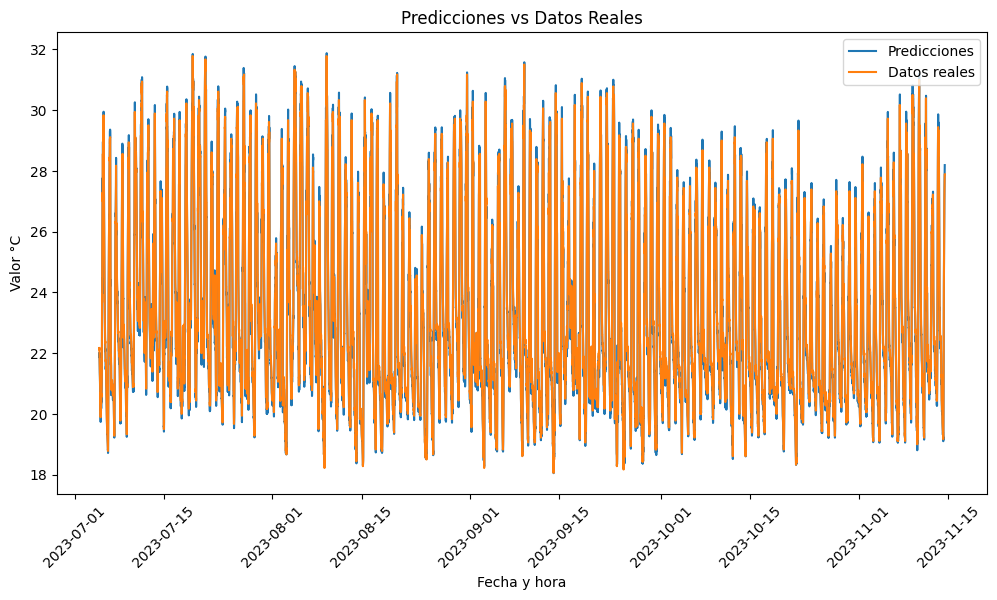

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Lee el CSV
df = pd.read_csv('/content/datos_actualizados2.csv')

# Convierte la columna 'Fecha y hora' a tipo datetime si no está en ese formato
df['Fecha y hora'] = pd.to_datetime(df['Fecha y hora'])

# Selecciona la columna 'Fecha y hora' como índice si no lo es ya
if 'Fecha y hora' not in df.index:
    df.set_index('Fecha y hora', inplace=True)

# Obtén la serie temporal de temperaturas
serie_temp = df['Valor °C'].values.reshape(-1, 1)  # La red neuronal espera un arreglo bidimensional

# Normaliza los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
serie_temp_normalizada = scaler.fit_transform(serie_temp)

# Función para preparar los datos para la red neuronal
def crear_ventanas(datos, pasos):
    X, y = [], []
    for i in range(len(datos)-pasos):
        ventana = datos[i:(i+pasos), 0]
        X.append(ventana)
        y.append(datos[i + pasos, 0])
    return np.array(X), np.array(y)

# Número de pasos de tiempo para predecir el siguiente
pasos_tiempo = 10

# Crear datos de entrenamiento y prueba
X, y = crear_ventanas(serie_temp_normalizada, pasos_tiempo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Crear el modelo MLP con 50 capas
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(pasos_tiempo,)))
for _ in range(48):  # Agregar 48 capas más
    model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Realizar predicciones en datos de prueba
predictions = model.predict(X_test)

# Desnormalizar las predicciones y los datos de prueba
predictions_desnormalizadas = scaler.inverse_transform(predictions)
y_test_desnormalizadas = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular métricas de evaluación
mse = mean_squared_error(y_test_desnormalizadas, predictions_desnormalizadas)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_desnormalizadas, predictions_desnormalizadas)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Obtener las fechas correspondientes a los datos de prueba
fechas_test = df.index[-len(y_test):]  # Fechas correspondientes a los datos de prueba

# Visualización de resultados con fechas
plt.figure(figsize=(12, 6))
plt.plot(fechas_test, predictions_desnormalizadas, label='Predicciones')
plt.plot(fechas_test, y_test_desnormalizadas, label='Datos reales')
plt.legend()
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor °C')
plt.xticks(rotation=45)  # Rotar etiquetas en el eje x para mejor visualización
plt.show()


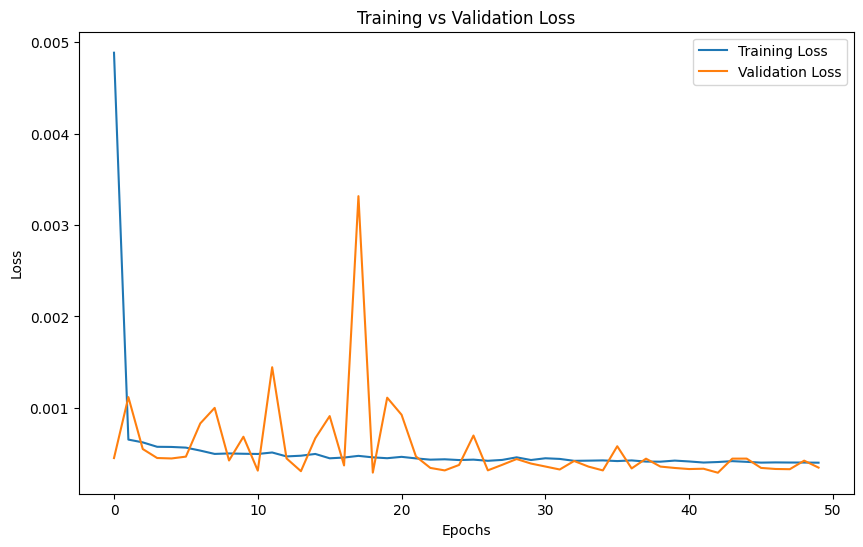

In [ ]:
# Plot loss
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

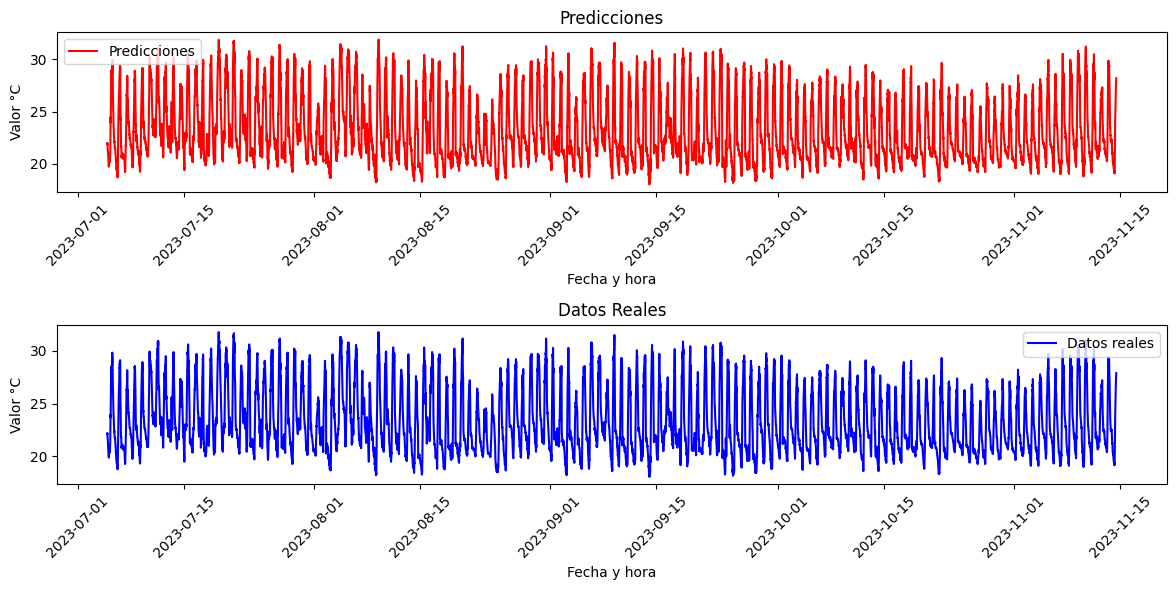

In [ ]:
# Graficar predicciones y datos reales por separado
plt.figure(figsize=(12, 6))

# Gráfico de predicciones
plt.subplot(2, 1, 1)
plt.plot(fechas_test, predictions_desnormalizadas, label='Predicciones', color='red')
plt.legend()
plt.title('Predicciones')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor °C')
plt.xticks(rotation=45)  # Rotar etiquetas en el eje x para mejor visualización

# Gráfico de datos reales
plt.subplot(2, 1, 2)
plt.plot(fechas_test, y_test_desnormalizadas, label='Datos reales', color='blue')
plt.legend()
plt.title('Datos Reales')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor °C')
plt.xticks(rotation=45)  # Rotar etiquetas en el eje x para mejor visualización

plt.tight_layout()  # Ajustar el diseño para evitar solapamiento
plt.show()